# Goal<br>
* Develop a machine learning model using bag of words and vectorization that will take in Netflix descriptions of shows in it's database and predict wether the show matching each discription belongs to a given genre<br>

* Inestigate wether this technique can be inhanced by identifying "unique words," words that only occur in discriptions belonging to that genre

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



import warnings
warnings.filterwarnings("ignore")

import wrangle as w
import explore as e
import model as m

#pd.set_option('display.max_colwidth', None)

# Wrangle

* Data acquired from [Kaggle](https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv)

* Each row in the data represents a show appearing on Netflix at the time data was collected
* Columns were restricted to description and genre
* The following modifications were made when cleaning the text in description
     * Converted to lowercase
     * Special characters removed
     * Remove non-ascii characters
     * Lemmatize tokens
     * Remove stop words using standard list plus two letter words
* Boolean columns for each genre appearing in the genres column were added 
     * These columns indicate if the show belonged to that genre
* Dataset contains 5791 rows after being prepared 
* full dataset was split into train, validate and test sets 
     * Train set contains 3242 rows
     * Validate set contains 1390 rows
     * Test set contains 1159 rows

In [2]:
#acquire and prepare data
df = w.get_show_data()

# split data into train, validate and prep
train, validate, test = w.split_my_data(df)

# print number ow rows in train
print(f"Train set contains {train.shape[0]} rows of data")
print(f"Validate set contains {validate.shape[0]} rows of data")
print(f"Test set contains {test.shape[0]} rows of data")

Train set contains 3242 rows of data
Validate set contains 1390 rows of data
Test set contains 1159 rows of data


# Explore

## 1. Choose a genre as a test case using the following criteria:
   * Genre has large representation in the data
   * Genre has a large number of unique words
   * Genre has a high number of unique words appearing in each description
   * Genre is relatively easy for a human to intuit 

## 2. Explore the chosen genre:
   * How much of the data is represented by the chosen genre?
   * What is the distribution of word and document frequency for the chosen genre?
   * What words have the highest and lowest word and document frequency?
   * Is it possible to predict the chosen genre using unique words?

In [3]:
# get set of genres
gen_set = e.get_gens(train)

# get relative word frequency list and list of only the numbers
word_freq = e.get_word_freq(train)
word_counts = e.get_counts(word_freq)

# get relative document frequency list and list of only the numbers
doc_freq = e.get_doc_freq(train)
doc_counts = e.get_counts(doc_freq)

## 1. Choose a Test Case 

### What is the distribution of genres in the train data?

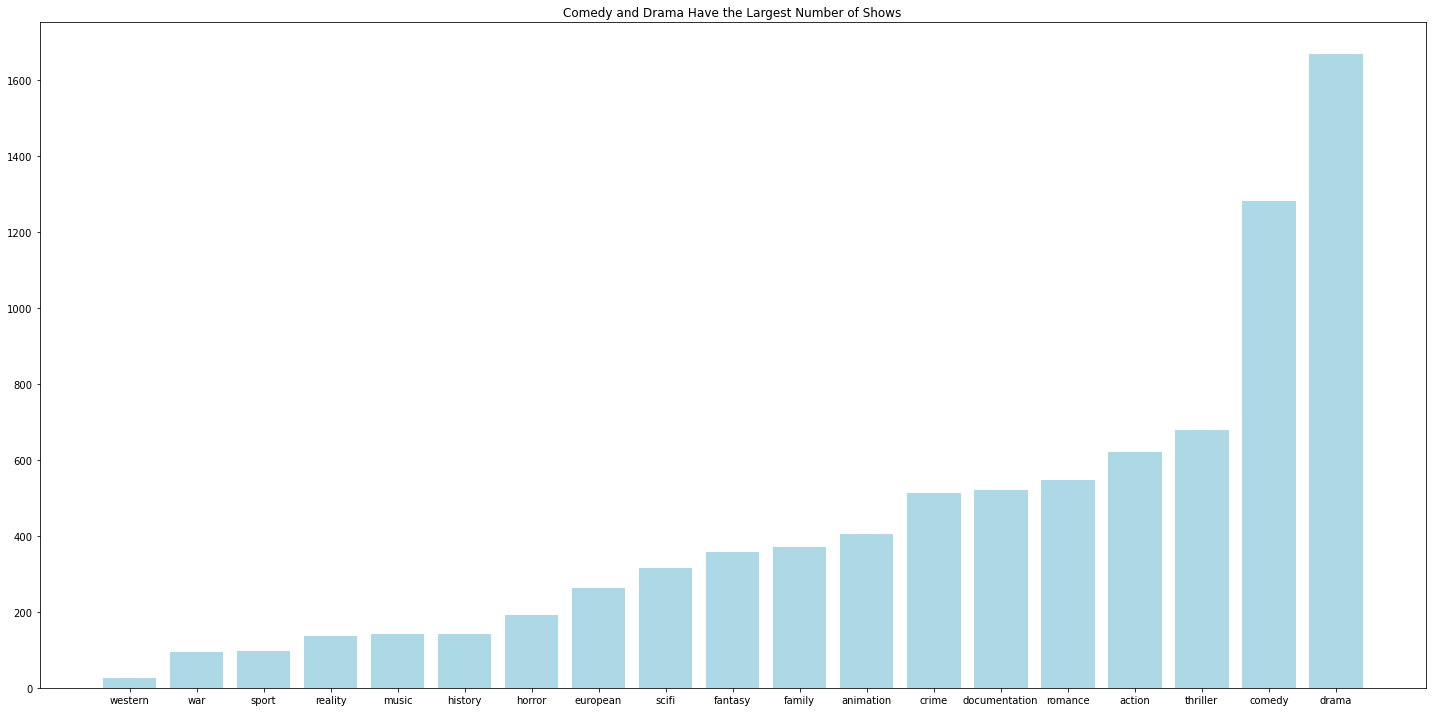

In [4]:
# display distribution of genres
shows_per_gen = e.get_shows_per_gen(train, gen_set)
e.get_bar(shows_per_gen, "Comedy and Drama Have the Largest Number of Shows")

* Comedy and Drama are by far the most highly represented genre in the training data.

### How many different unique words appear in each genre? 

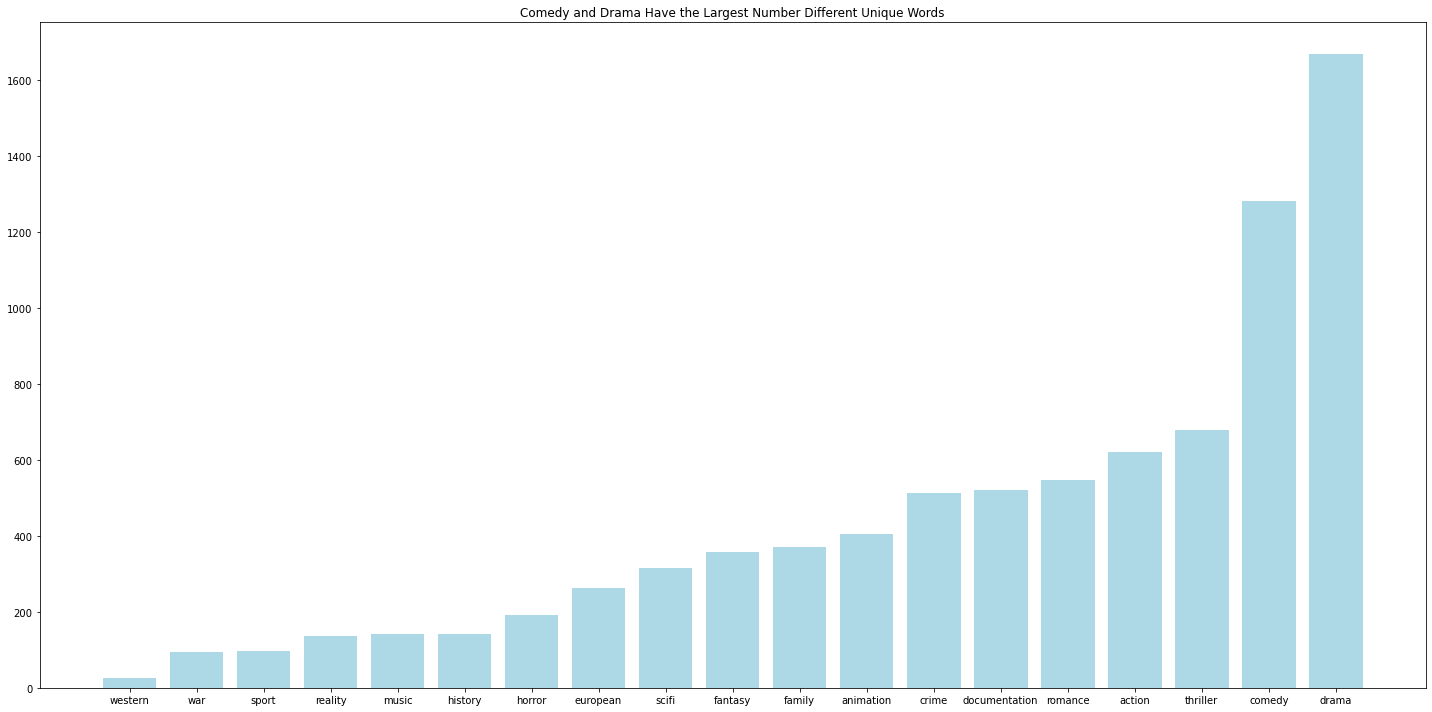

In [5]:
# display number of different unique words in each genre
unique_words_per_gen = e.get_unique_words_per_gen(train, gen_set)
e.get_bar(shows_per_gen, "Comedy and Drama Have the Largest Number Different Unique Words")

* Comedy and Drama contain by far the largest number of differint unique words

### What is the average number of times unique words appear in descriptions of each genre?

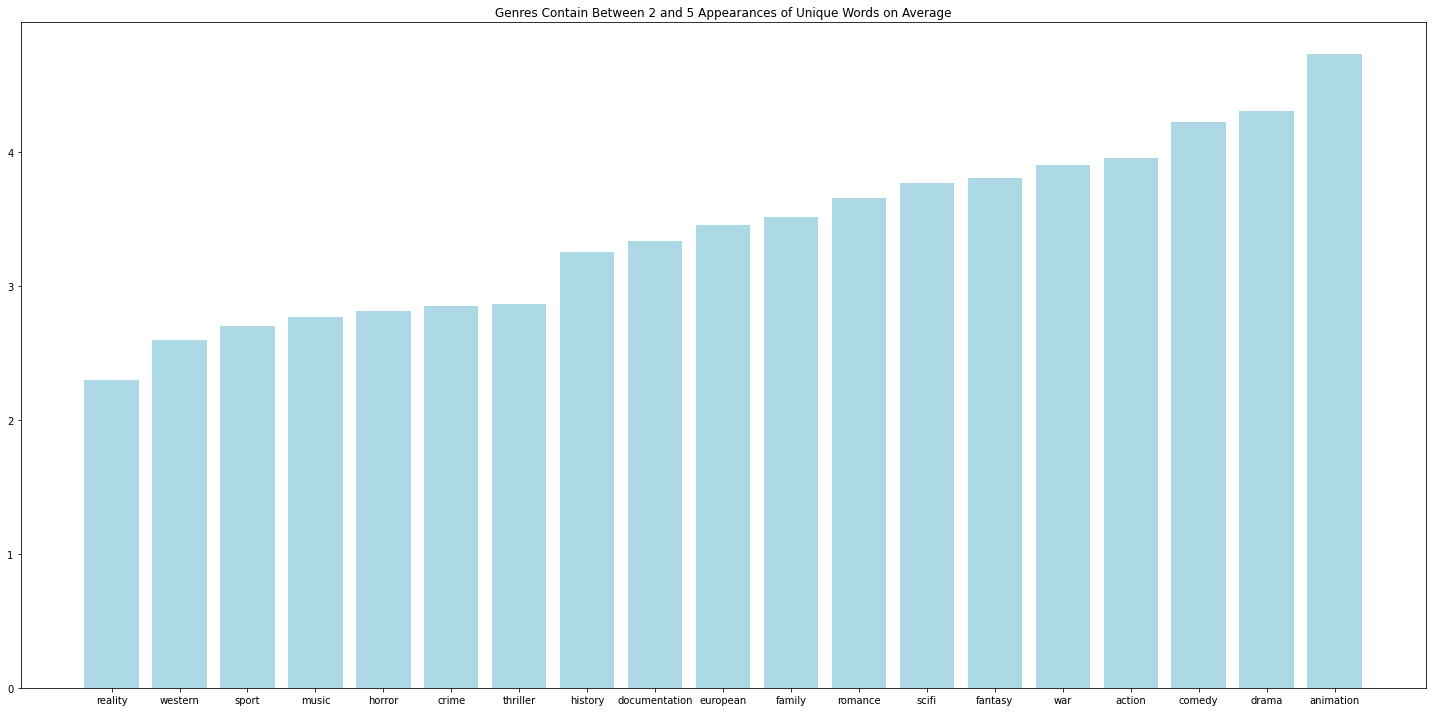

In [21]:
# get frequency of unique words pre genre
unique_word_appearance_per_genre = e.get_unique_word_appearance_per_genre(train, gen_set)
e.get_bar(unique_word_appearance_per_genre, "Genres Contain Between 2 and 5 Appearances of Unique Words on Average")

* Not a great deal of variance in unique word appearance frequency
* Animation has the highest appearace frequency
* Comedy and Drama are close behind

## Test Case Conclution

* Comedy and Drama have high values in all of the testable criterea
   * Representation in the data
   * Number of unique words
   * High number of unique words appearing in each description
* Either genre would make a reasonable choice
* The last criteria is how easily the genre would be to intuit for a human
    * Comedy seems to me the earier of the two genres for a human to intuit 

**For these reasons I am choosing comedy as the test case for this project**

## 2) Explore the Comedy Genre

* What percent of the data is classified as a Comedy?
* Are there any words that appear more or less frequently across comedy or non-comedy show descriptions? <br>(Overall/by document)

**How much of the data is Comedy?**

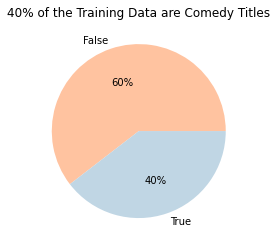

In [9]:
e.omni_pie(train.comedy, "40% of the Training Data are Comedy Titles")

## What does the relative occurance of words in comedy or non-comedy films tell us?


**The following chart shows a histogram of the relative document frequency of each unique word appearing in film descriptions**
<br>
The number is calculated in the following way: <br>
number of comedy documents the word appears in minus the number of non-comedy documents the word appears in

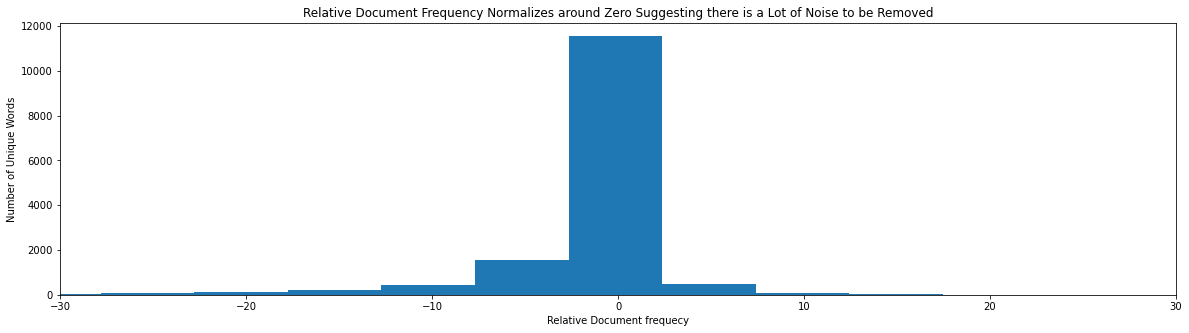

In [10]:
e.get_hist_doc(doc_counts)

* Data appears to normalize around 0 however the steps are steeper on the positive side
* Skew is likely do to the 60/40 imbalance in the data

**The following chart shows the relative frequency of each unique word appearing film descriptions**
The number is calculated in the following way: <br>
number of times the word appears in comedy documents minus number of times the word appears in non-comedy documents

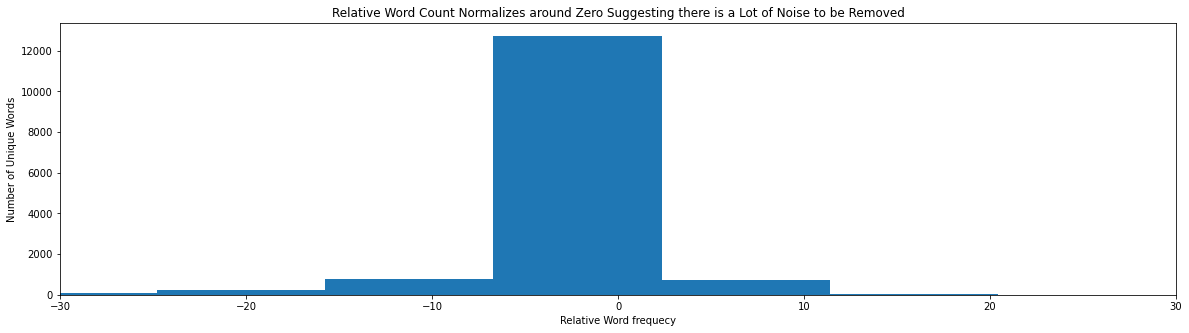

In [11]:
e.get_hist_word(word_counts)

* Data appears to normalize around -2 and there seems to be more negative values than positive ones
* Skew is likely do to the 60/40 imbalance in the data

Words that do not have a significant difference in apearances between comedy and non-comedy films will not be useful in guiding the model. Looking at the results of these distributions tells me that once the data is vectorized there will be a lot of noise words that can be dropped to make sure that signal words are having a stronger impact on the model.

**As a quick sanity test lets take a look at our top 15 most extream values for document and word frequency**

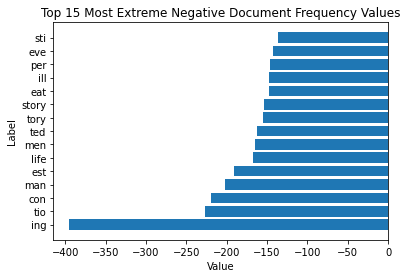

In [12]:
e.get_doc_ext(dict(doc_freq[:15]), "Top 15 Most Extreme Negative Document Frequency Values")

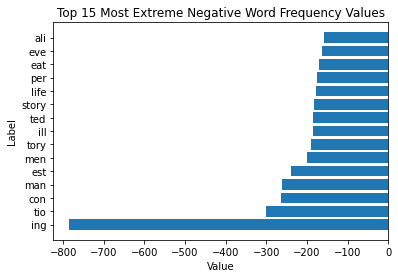

In [13]:
e.get_doc_ext(dict(word_freq[:15]), "Top 15 Most Extreme Negative Word Frequency Values")

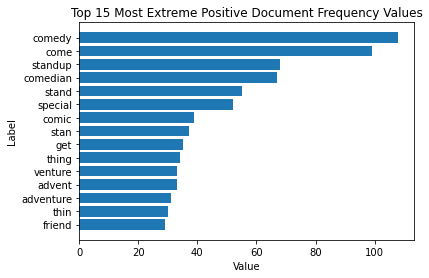

In [14]:
e.get_doc_ext(dict(doc_freq[-15:]), "Top 15 Most Extreme Positive Document Frequency Values")

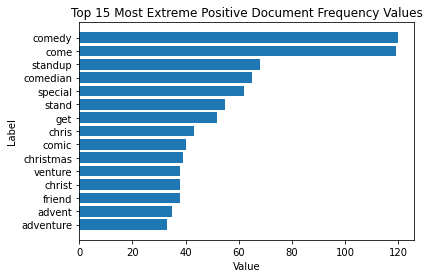

In [15]:
e.get_doc_ext(dict(word_freq[-15:]), "Top 15 Most Extreme Positive Document Frequency Values")

* Extreme negative values seem suspect due to the imbalance in the data words commen to both comedy and non-comedy films may have a large negative value because there are more non-comedy films in the data.
* Extreme positive value words are intuatively indicitive of the comedy genre and servive in spite of the data imbalance working against them. They seem like good indicators.

**Predicting Using Unique Words** <br>
Descriptions of comedies in our test data contain about 4000 unique words. On average 3 of these words will appear in a given comedy description. The following will be an attempt to classify genres based on unique words without using a machine learning model.

In [16]:
# get set of words occuring in comedy and non-comedy descriptions
com_train = e.get_description_set_of_words(train[train.comedy == True])
non_train = e.get_description_set_of_words(train[train.comedy == False])

# get set of words appearing in only comedy or non-comedy descriptions
com_unique_train = com_train.difference(non_train)
non_unique_train = non_train.difference(com_train)

# get train and validate dataframes with only 
train_evaluation_df = train[['description','comedy']]
validate_evaluation_df = validate[['description','comedy']]

In [17]:
def contains_matching_item(set1, set2):
    '''takes in two sets returns if fist set contains an item that is also in the 2nd set'''
    
    return len(set1.difference(set2)) != len(set1)

def is_present_value(value, set1, set2):
    '''takes in a pandas value representing a film description and two sets 
       returns value based on weather words in the description are in either of the sets'''
    
    value = set(value.split(' '))
    
    if contains_matching_item(value, set1) and (contains_matching_item(value, set2)):
        
        return "contains both"
    
    elif contains_matching_item(value, set1):
        
        return True
    
    elif contains_matching_item(value, set2):
        
        return False
    
    else:
        
        return "contains niether";
    
def by_number_value(value, gen_set, non_set):
    '''takes in a pandas value representing a film description and two sets 
       returns value based on number of words in the description appearing in each set'''
    # get count of number of words in description that are in gen_set and non_gen set
    
    value = value.split(' ')
    
    gen_set_count = 0
    
    non_set_count = 0
    
    for item in value:
        
        if item in set1:
            
            gen_set_count += 1
            
        if item in set2:
            
            non_set_count += 1
            
    # return value based on which set contains the most words from the description
    
    if gen_set_count == non_set_count:
        
        return "equal count"
    
    elif gen_set_count > non_set_count:
        
        return True
    
    elif gen_set_count < non_set_count:
        
        return False
    
    else:
        
        return "did not catch";
    
    
def get_predictions_presence(df, gen_uniques, non_gen_uniques):
    '''Takes in df containing film description set of in-genre words and set of out of genre words'''
    
    df['prediction'] = df.description.apply(lambda value : is_present_value(value, gen_uniques, non_gen_uniques)) 
    df['evaluation'] = df['comedy'] == df['prediction']
    
    print("Prediction Value Counts")
    print("-----------------------")
    print(df.prediction.value_counts())
    print()
    print("Evaluation Value Counts")
    print("-----------------------")
    print(df.evaluation.value_counts())
    print()
    print("Accuracy")
    print("-----------------------")
    print(round(df.evaluation.mean(), 2) * 100)
    print()
    print("Accuracy True/False only")
    print("-----------------------")
    print(round(df.evaluation[(df.prediction == True) | (df.prediction == False)].mean(), 2) * 100)
    
def get_predictions_number(df, gen_uniques, non_gen_uniques):
    
    df['prediction'] = df.description.apply(lambda value : by_number_value(value, gen_uniques, non_gen_uniques)) 
    df['evaluation'] = df['comedy'] == df['prediction']
    
    print("Prediction Value Counts")
    print("-----------------------")
    print(df.prediction.value_counts())
    print()
    print("Evaluation Value Counts")
    print("-----------------------")
    print(df.evaluation.value_counts())
    print()
    print("Accuracy")
    print("-----------------------")
    print(round(df.evaluation.mean(), 2) * 100)
    print()
    print("Accuracy True/False only")
    print("-----------------------")
    print(round(df.evaluation[(df.prediction == True) | (df.prediction == False)].mean(), 2) * 100)

In [18]:
get_predictions_presence(train_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
False               1837
True                1168
contains niether     237
Name: prediction, dtype: int64

Evaluation Value Counts
-----------------------
True     3005
False     237
Name: evaluation, dtype: int64

Accuracy
-----------------------
93.0

Accuracy True/False only
-----------------------
100.0


In [19]:
get_predictions_presence(validate_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
contains both       512
False               486
contains niether    213
True                179
Name: prediction, dtype: int64

Evaluation Value Counts
-----------------------
False    941
True     449
Name: evaluation, dtype: int64

Accuracy
-----------------------
32.0

Accuracy True/False only
-----------------------
68.0


In [20]:
get_predictions_number(validate_evaluation_df, com_unique_train, non_unique_train)

NameError: name 'set1' is not defined

In [ ]:
non_unique_train

# Modeling

I will be examining different tequniques for building the most accurate possible model. Techniques include using word count vs TF-IDF, differint machine learning classification models, and a number of feature engineering ideas. For this reason models will be graded on overall accuracy above all. Ties will be decided by fewist false negatives. As a buisness case, it seems better to me to present a movie to a customer out of genre then to fail to present an in ingenre film that might increase that customers watchtime, provided these occurances are kept to a minimum.
Because the data has a 60/40 split my beginning baseline is 60% and will hopefully be improved on throughout the modeling process.

In [ ]:
# seperate train, validate and test data into X (description) and y (comedy)
train_X = train[['description']].reset_index(drop=True)
train_y = train[['comedy']].reset_index(drop=True)

validate_X = validate[['description']].reset_index(drop=True)
validate_y = validate[['comedy']].reset_index(drop=True)

test_X = test[['description']].reset_index(drop=True)
test_y = test[['comedy']].reset_index(drop=True)

## Count Analysis - Full Vectorization Array

In [ ]:
train_counts, validate_counts, test_counts = m.get_vector_counts(train_X, validate_X, test_X)

In [ ]:
# m.get_acc_table(train_counts, train_y, validate_counts, validate_y)

Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 64.82%
Random Forest  Train: 99.97% Validate: 69.86%
K Neighbors  Train: 62.86000000000001% Validate: 60.5%
Logistic Regression Train: 99.78% Validate: 71.8%

When predicting on raw counts the logistic regression and random forest models both broke 70% accuracy. Lets see if I can improve on that by cutting out some of the noise. For the next two attempts I will drop all of the words that with a 0 relative frequency for document and raw count frequency. 

## Count Analysis - Drop low Relative Frequency - Raw Counts

In [ ]:
def remove_low_freq(df, freq_dict, threshold):
    ''' removes columns from df if abs val of relative freq is equal or less than input number '''
    
    for col in df.columns.to_list():
        
        if abs(freq_dict[col]) <= threshold:
            
            df = df.drop(columns=[col])
    
    return df

In [ ]:
def get_acc_after_freq_drop(train_X, train_y, validate_X, validate_y, freq_lst, threshold):
    ''' get accuracy table after dropping words from training data 
        that have a relative freq less than the input number'''
    
    
    train_X = remove_low_freq(train_X, dict(freq_lst), threshold)
    validate_X = remove_low_freq(validate_X, dict(freq_lst), threshold)

    print(f"Drop threshold is {threshold}")
    m.get_acc_table(train_X, train_y, validate_X, validate_y)

In [ ]:
# for item in [0,5,20,50,100]:
    
#     get_acc_after_freq_drop(train_counts, train_y, validate_counts, validate_y, word_freq, item)

Drop threshold is 0

Accuracy Scores for Drop Threshold 0
---------------

Decision Tree  Train: 99.97% Validate: 65.97%
Random Forest  Train: 99.97% Validate: 70.07%
K Neighbors  Train: 63.13999999999999% Validate: 60.22%
Logistic Regression Train: 99.6% Validate: 71.94%

Drop threshold is 5
Accuracy Scores for Drop Threshold 0
---------------
Decision Tree  Train: 99.94% Validate: 63.88%
Random Forest  Train: 99.94% Validate: 70.22%
K Neighbors  Train: 80.35% Validate: 58.63%
Logistic Regression Train: 88.99000000000001% Validate: 69.28%

Drop threshold is 20
Accuracy Scores for Drop Threshold 0
---------------
Decision Tree  Train: 98.11999999999999% Validate: 61.8%
Random Forest  Train: 98.11999999999999% Validate: 65.18%
K Neighbors  Train: 75.44999999999999% Validate: 60.5%
Logistic Regression Train: 75.72% Validate: 69.64%

Drop threshold is 50
Accuracy Scores
---------------
Decision Tree  Train: 80.97% Validate: 63.239999999999995%
Random Forest  Train: 80.97% Validate: 64.46%
K Neighbors  Train: 70.82000000000001% Validate: 62.519999999999996%
Logistic Regression Train: 68.72% Validate: 66.03999999999999%

Drop threshold is 100
Accuracy Scores
---------------
Decision Tree  Train: 67.4% Validate: 62.519999999999996%
Random Forest  Train: 67.4% Validate: 62.59%
K Neighbors  Train: 63.629999999999995% Validate: 58.35%
Logistic Regression Train: 64.1% Validate: 63.31%









## Count Analysis - Drop low Relative Frequency - Document Counts

In [ ]:
# for item in [0,5,20,50,100]:

#     get_acc_after_freq_drop(train_counts, train_y, validate_counts, validate_y, doc_freq, item)

Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 65.9%
Random Forest  Train: 99.97% Validate: 70.22%
K Neighbors  Train: 63.39% Validate: 60.36%
Logistic Regression Train: 99.53999999999999% Validate: 71.37%
Drop threshold is 5
Accuracy Scores
---------------
Decision Tree  Train: 99.94% Validate: 63.449999999999996%
Random Forest  Train: 99.94% Validate: 69.57%
K Neighbors  Train: 81.0% Validate: 56.910000000000004%
Logistic Regression Train: 87.79% Validate: 70.28999999999999%
Drop threshold is 20
Accuracy Scores
---------------
Decision Tree  Train: 97.89999999999999% Validate: 59.93000000000001%
Random Forest  Train: 97.89999999999999% Validate: 65.18%
K Neighbors  Train: 75.94% Validate: 59.14%
Logistic Regression Train: 74.61% Validate: 68.56%
Drop threshold is 50
Accuracy Scores
---------------
Decision Tree  Train: 77.64% Validate: 63.739999999999995%
Random Forest  Train: 77.64% Validate: 64.75%
K Neighbors  Train: 67.30000000000001% Validate: 57.989999999999995%
Logistic Regression Train: 67.97999999999999% Validate: 66.62%
Drop threshold is 100
Accuracy Scores
---------------
Decision Tree  Train: 66.38% Validate: 62.73%
Random Forest  Train: 66.38% Validate: 62.519999999999996%
K Neighbors  Train: 60.18% Validate: 56.55%
Logistic Regression Train: 63.970000000000006% Validate: 63.019999999999996%

Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 0.999691548426897 Validate: 0.6589928057553956
Random Forest  Train: 0.999691548426897 Validate: 0.702158273381295
KNeighbors  Train: 0.6338679827267119 Validate: 0.6035971223021582
Logistic  Train: 0.9953732264034546 Validate: 0.7136690647482015
Drop threshold is 5
Accuracy Scores
---------------
Decision Tree  Train: 0.999383096853794 Validate: 0.6345323741007194
Random Forest  Train: 0.999383096853794 Validate: 0.6956834532374101
KNeighbors  Train: 0.8099938309685379 Validate: 0.5690647482014388
Logistic  Train: 0.8778531770512029 Validate: 0.7028776978417266
Drop threshold is 20
Accuracy Scores
---------------
Decision Tree  Train: 0.9790252930289944 Validate: 0.5992805755395684
Random Forest  Train: 0.9790252930289944 Validate: 0.6517985611510791
KNeighbors  Train: 0.7594077729796422 Validate: 0.5913669064748202
Logistic  Train: 0.7461443553362123 Validate: 0.685611510791367
Drop threshold is 50
Accuracy Scores
---------------
Decision Tree  Train: 0.7763726095003084 Validate: 0.637410071942446
Random Forest  Train: 0.7763726095003084 Validate: 0.6474820143884892
KNeighbors  Train: 0.6730413325107958 Validate: 0.5798561151079137
Logistic  Train: 0.6798272671190623 Validate: 0.6661870503597123
Drop threshold is 100
Accuracy Scores
---------------
Decision Tree  Train: 0.6637877853177051 Validate: 0.6273381294964029
Random Forest  Train: 0.6637877853177051 Validate: 0.625179856115108
KNeighbors  Train: 0.6017890191239975 Validate: 0.5654676258992806
Logistic  Train: 0.6397285626156693 Validate: 0.6302158273381295

## TFIDF Analysis - Full Vectorization Array

In [ ]:
def get_vectorized_data(train_X, validate_X, test_X, vector):
    ''' Take in X values for train, validate and test
        Return values vectorized by count'''

    cv = vector

    train_X = cv.fit_transform(train_X['description'])
    validate_X = cv.transform(validate_X['description'])
    test_X = cv.transform(test_X['description'])

    # Retrieve the feature names (words) from the Vectorizer
    feature_names = cv.get_feature_names()

    # Create DataFrames for train_counts and validate_counts
    train_X = pd.DataFrame(train_X.todense(), columns=feature_names)
    validate_X = pd.DataFrame(validate_X.todense(), columns=feature_names)
    test_X = pd.DataFrame(test_X.todense(), columns=feature_names)

    return train_X, validate_X, test_X

In [ ]:
train_tfidf, validate_tfidf, test_tfidf = get_vectorized_data(train_X, validate_X, test_X, TfidfVectorizer())

In [ ]:
# m.get_acc_table(train_tfidf, train_y, validate_tfidf, validate_y)

Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 61.58%
Random Forest  Train: 99.97% Validate: 70.0%
K Neighbors  Train: 80.35% Validate: 67.63%
Logistic Regression Train: 88.25% Validate: 70.43%

# Word

In [ ]:
# for item in [0,5,20,50,100]:
    
#     get_acc_after_freq_drop(train_tfidf, train_y, validate_tfidf, validate_y, word_freq, item)

Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 62.3%
Random Forest  Train: 99.97% Validate: 69.93%
K Neighbors  Train: 40.78% Validate: 40.0%
Logistic Regression Train: 87.51% Validate: 71.00999999999999%
Drop threshold is 5
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 60.14000000000001%
Random Forest  Train: 99.97% Validate: 67.05%
K Neighbors  Train: 84.15% Validate: 55.11000000000001%
Logistic Regression Train: 77.75999999999999% Validate: 69.5%
Drop threshold is 20
Accuracy Scores
---------------
Decision Tree  Train: 99.22999999999999% Validate: 59.86%
Random Forest  Train: 99.22999999999999% Validate: 64.75%
K Neighbors  Train: 75.85% Validate: 59.709999999999994%
Logistic Regression Train: 71.16% Validate: 68.35%
Drop threshold is 50
Accuracy Scores
---------------
Decision Tree  Train: 92.69% Validate: 60.650000000000006%
Random Forest  Train: 92.69% Validate: 62.88%
K Neighbors  Train: 72.92% Validate: 62.88%
Logistic Regression Train: 67.15% Validate: 66.55%
Drop threshold is 100
Accuracy Scores
---------------
Decision Tree  Train: 82.54% Validate: 57.34%
Random Forest  Train: 82.54% Validate: 58.85%
K Neighbors  Train: 67.77% Validate: 60.42999999999999%
Logistic Regression Train: 63.6% Validate: 63.019999999999996%

# Doc

In [ ]:
# for item in [0,5,20,50,100]:
    
#     get_acc_after_freq_drop(train_tfidf, train_y, validate_tfidf, validate_y, doc_freq, item)

Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 61.08%
Random Forest  Train: 99.97% Validate: 69.86%
K Neighbors  Train: 73.63% Validate: 50.07%
Logistic Regression Train: 87.11% Validate: 70.36%
Drop threshold is 5
Accuracy Scores
---------------
Decision Tree  Train: 99.94% Validate: 59.06%
Random Forest  Train: 99.94% Validate: 68.27%
K Neighbors  Train: 86.21% Validate: 56.76%
Logistic Regression Train: 77.79% Validate: 70.0%
Drop threshold is 20
Accuracy Scores
---------------
Decision Tree  Train: 99.14% Validate: 61.01%
Random Forest  Train: 99.14% Validate: 64.96%
K Neighbors  Train: 75.91% Validate: 59.419999999999995%
Logistic Regression Train: 70.85000000000001% Validate: 68.2%
Drop threshold is 50
Accuracy Scores
---------------
Decision Tree  Train: 90.9% Validate: 61.58%
Random Forest  Train: 90.9% Validate: 63.09%
K Neighbors  Train: 70.57% Validate: 59.5%
Logistic Regression Train: 66.35% Validate: 66.62%
Drop threshold is 100
Accuracy Scores
---------------
Decision Tree  Train: 81.39999999999999% Validate: 57.34%
Random Forest  Train: 81.39999999999999% Validate: 58.56%
K Neighbors  Train: 67.06% Validate: 60.86%
Logistic Regression Train: 63.629999999999995% Validate: 63.019999999999996%